In [1]:
%matplotlib inline

In [2]:
#@title
import jax
import numpy as np

import jax.numpy as jnp
from jax import grad, jit, vmap
from jax import random

try:
  import flax
except ModuleNotFoundError:
  !pip install --quiet flax
  import flax

try:
  import optax
except ModuleNotFoundError:
  !pip install --quiet optax
  import optax

from flax import linen as nn
from flax.training import train_state

from tqdm import trange
from functools import partial
from matplotlib import pyplot as plt

## Data Generation

In [3]:
from typing import NamedTuple, Any

def sample_data(key, bs):
  keys = random.split(key, 3)
  x_1 = random.randint(keys[0], minval=0, maxval=2, shape=(bs, 2))
  x_1 = 3*(x_1.astype(jnp.float32)-0.5)
  x_1 += 4e-1*random.normal(keys[1], shape=(bs,2))
  return x_1

t_0, t_1 = 0.0, 1.0
beta_0 = 0.1
beta_1 = 20.0
log_alpha = lambda t: -0.5*t*beta_0-0.25*t**2*(beta_1-beta_0)
# log_sigma = lambda t: jnp.log(jnp.sqrt(-jnp.expm1(-t*beta_0-0.5*t**2*(beta_1-beta_0))))
log_sigma = lambda t: jnp.log(t)
dlog_alphadt = jax.grad(lambda t: log_alpha(t).sum())
dlog_sigmadt = jax.grad(lambda t: log_sigma(t).sum())
# beta_t = s_t d/dt log(s_t/alpha_t)
# beta = lambda t: jnp.exp(log_sigma(t))*(dlog_sigmadt(t) - dlog_alphadt(t))
beta = lambda t: (1 + 0.5*t*beta_0 + 0.5*t**2*(beta_1-beta_0))

def q_t(key, data, t):
  eps = random.normal(key, shape=data.shape)
  x_t = jnp.exp(log_alpha(t))*data + jnp.exp(log_sigma(t))*eps
  return eps, x_t

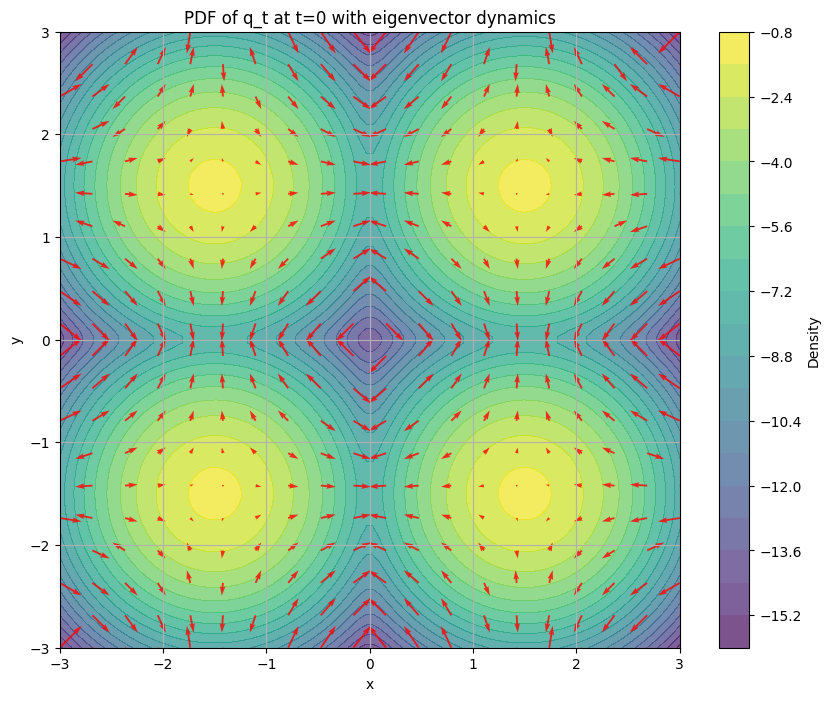

In [39]:
def q_0(state):
    """Analytical PDF of q_t at t=0 for array input state = [x, y]"""
    centers = jnp.array([[-1.5, -1.5], [-1.5, 1.5], [1.5, -1.5], [1.5, 1.5]])
    sigma = 0.4
    
    # Sum of 4 Gaussians
    pdf = jnp.zeros_like(state[0])
    for c in centers:
        pdf += jnp.exp(-((state[0] - c[0])**2 + (state[1] - c[1])**2)/(2*sigma**2))
    pdf /= (2*jnp.pi*sigma**2 * 4)  # Normalize
    return jnp.log(pdf)
q_0_vmap = jax.vmap(q_0)
q_0_vmap = jax.jit(q_0_vmap)

grad_q0 = jax.grad(q_0)
q0_hess = jax.hessian(q_0)

def eigvec_dynamics(state):
    """Compute vector field based on smallest eigenvector of Hessian"""
    grad_x = grad_q0(state)
    
    H = q0_hess(state)
    eig_vals, eig_vecs = jnp.linalg.eigh(H)
    smallest_eigvec = eig_vecs[0]
    
    x_dot = -grad_x + 2 * jnp.dot(grad_x, smallest_eigvec) * smallest_eigvec
    
    return x_dot

eigvec_dynamics_vmap = jax.vmap(eigvec_dynamics)
eigvec_dynamics_vmap = jax.jit(eigvec_dynamics_vmap)

N = 100
# Create grid for plotting
x = jnp.linspace(-3, 3, N)
y = jnp.linspace(-3, 3, N)
X, Y = jnp.meshgrid(x, y)
grid_flat = jnp.stack([X.flatten(), Y.flatten()], axis=1)
Z = q_0_vmap(grid_flat)
Z = Z.reshape(N, N)

# Create sparser grid for quiver plot
nx = ny = 20
x_quiver = jnp.linspace(-3, 3, nx)
y_quiver = jnp.linspace(-3, 3, ny)
X_quiver, Y_quiver = jnp.meshgrid(x_quiver, y_quiver)
grid_flat_quiver = jnp.stack([X_quiver.flatten(), Y_quiver.flatten()], axis=1)

# Compute vector field
vectors = eigvec_dynamics_vmap(grid_flat_quiver)
U = vectors[:,0].reshape(nx, ny)  # Changed indexing and reshaping
V = vectors[:,1].reshape(nx, ny)  # Changed indexing and reshaping

# Plot
plt.figure(figsize=(10, 8))
plt.contourf(X, Y, Z, levels=20, cmap='viridis', alpha=0.7)
plt.colorbar(label='Density')
plt.quiver(X_quiver, Y_quiver, U, V, color='red', alpha=0.8)
plt.title('PDF of q_t at t=0 with eigenvector dynamics')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid()
plt.show()

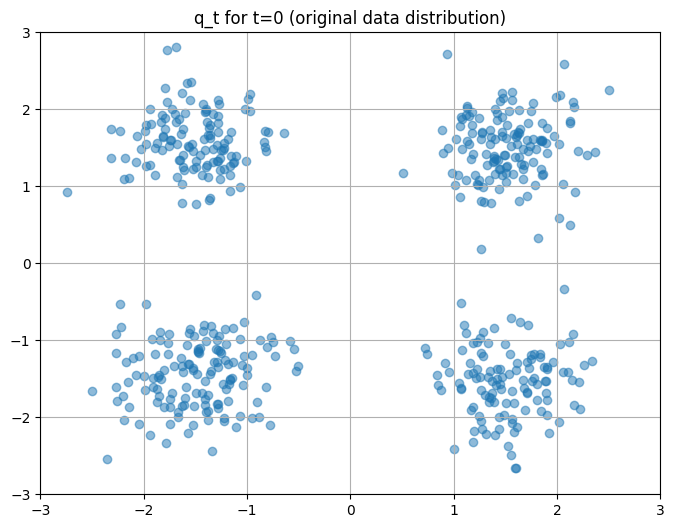

In [26]:
key, sample_key, q_key = random.split(key, 3)
data = sample_data(sample_key, bs=512)
_, x_0 = q_t(q_key, data, 0.0)  # t=0

plt.figure(figsize=(8, 6))
plt.scatter(x_0[:,0], x_0[:,1], alpha=0.5)
plt.title('q_t for t=0 (original data distribution)')
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.grid()
plt.show()

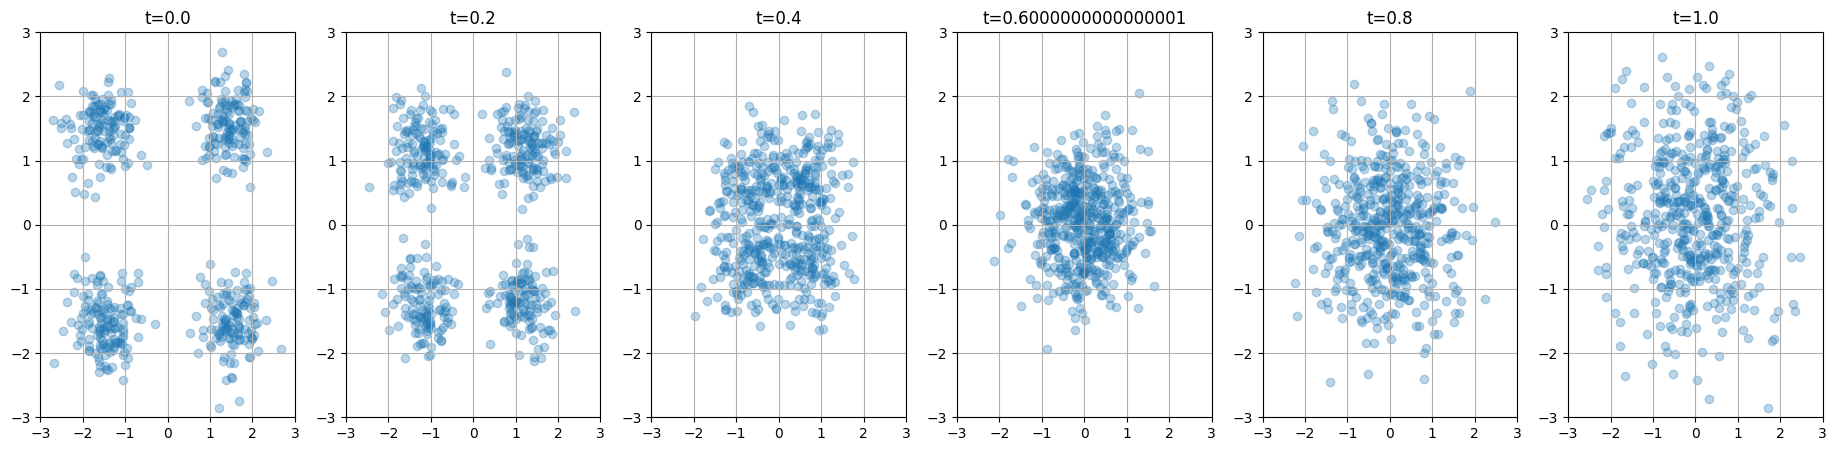

In [10]:
seed = 0
np.random.seed(seed)
key = random.PRNGKey(seed)
bs = 512
t_axis = np.linspace(0.0, 1.0, 6)

plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs), t_axis[i])
  plt.scatter(x_t[:,0], x_t[:,1], alpha=0.3)
  plt.title(f't={t_axis[i]}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()

## Define the Model

In [11]:
class MLP(nn.Module):
  num_hid : int
  num_out : int

  @nn.compact
  def __call__(self, t, x):
    h = jnp.hstack([t,x])
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.relu(h)
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(features=self.num_hid)(h)
    h = nn.swish(h)
    h = nn.Dense(features=self.num_out)(h)
    return h

In [12]:
model = MLP(num_hid=512, num_out=x_t.shape[1])
print(model)

key, init_key = random.split(key)
optimizer = optax.adam(learning_rate=2e-4)
state = train_state.TrainState.create(apply_fn=model.apply,
                                      params=model.init(init_key, np.ones([bs,1]), x_t),
                                      tx=optimizer)

MLP(
    # attributes
    num_hid = 512
    num_out = 2
)


## Loss Function

In [13]:
def sm_loss(state, key, params, bs):
  keys = random.split(key, )
  sdlogqdx = lambda _t, _x: state.apply_fn(params, _t, _x)
  data = sample_data(keys[0], bs)
  t = random.uniform(keys[1], [bs,1])
  eps, x_t = q_t(keys[2], data, t)
  loss = ((eps + sdlogqdx(t, x_t))**2).sum(1)
  print(loss.shape, 'final.shape', flush=True)
  return loss.mean()

@partial(jax.jit, static_argnums=1)
def train_step(state, bs, key):
  grad_fn = jax.value_and_grad(sm_loss, argnums=2)
  loss, grads = grad_fn(state, key, state.params, bs)
  state = state.apply_gradients(grads=grads)
  return state, loss

key, loc_key = random.split(key)
state, loss = train_step(state, bs, loc_key)

(512,) final.shape


## Train Loop

In [14]:
num_iterations = 20_000

loss_plot = np.zeros(num_iterations)
key, loop_key = random.split(key)
for iter in trange(num_iterations):
  state, loss = train_step(state, bs, random.fold_in(loop_key, iter))
  loss_plot[iter] = loss

100%|██████████| 20000/20000 [00:29<00:00, 684.02it/s]


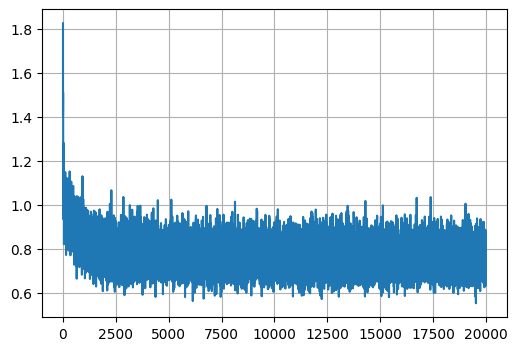

In [15]:
plt.figure(figsize=(6,4))
plt.plot(loss_plot)
plt.grid()

## Evaluation of the Trained Model

In [16]:
# v_t(x) = dlog(alpha)/dt x - s^2_t d/dt log(s_t/alpha_t) dlog q_t(x)/dx
@jax.jit
def vector_field(t,x,xi=0.0):
  sdlogqdx = lambda _t, _x: state.apply_fn(state.params, _t, _x)
  dxdt = dlog_alphadt(t)*x - beta(t)*sdlogqdx(t, x) - xi*beta(t)/jnp.exp(log_sigma(t))*sdlogqdx(t, x)
  return dxdt

In [17]:
dt = 1e-2
xi = 1.0
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
key, ikey = random.split(key, num=2)
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
x_gen = x_gen.at[:,0,:].set(random.normal(ikey, shape=(bs, x_t.shape[1])))
for i in trange(n):
  key, ikey = random.split(key, num=2)
  dx = -dt*vector_field(t, x_gen[:,i,:], xi) + jnp.sqrt(2*xi*beta(t)*dt)*random.normal(ikey, shape=(bs,2))
  x_gen = x_gen.at[:,i+1,:].set(x_gen[:,i,:] + dx)
  t += -dt

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 71.77it/s]


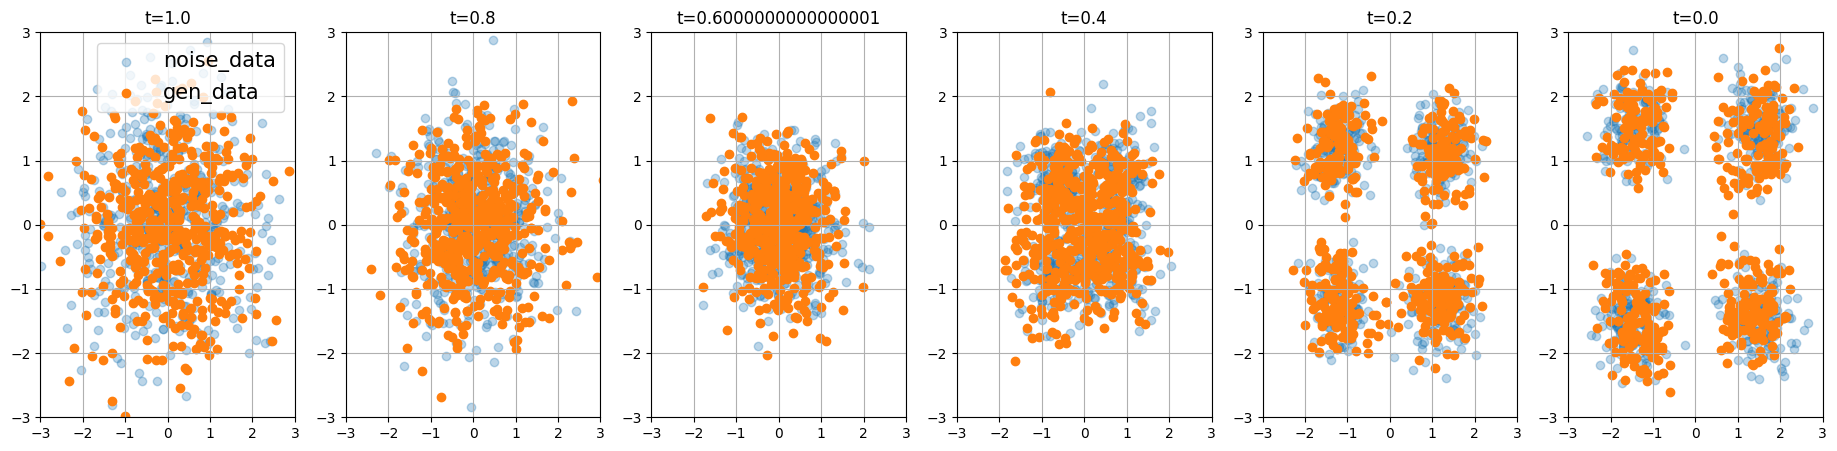

In [18]:
plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], bs), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data', alpha=0.3)
  plt.scatter(x_gen[:,int(n*(t_axis[i])),0], x_gen[:,int(n*(t_axis[i])),1], label='gen_data')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)

## Mode seeking

In general, let's say we want to conserve some function while we're generating the sample, i.e.
$$f_t(x_t) = \texttt{const}\,.$$
For this, let's write down the change of the function
$$\frac{d}{dt}f_t(x_t) = \frac{\partial}{\partial t} f_t(x_t) + \langle\nabla_x f_t(x_t), \frac{dx_t}{dt}\rangle = 0\,.$$
$$dt\cdot\frac{\partial}{\partial t} f_t(x_t) + \langle\nabla_x f_t(x_t), dx_t\rangle = 0\,.$$
From this equation, it's obvious that we have to project the increment of our variable $dx_t$ as follows
$$dx_t^\perp = dx_t - \left(dt\cdot\frac{\partial}{\partial t} f_t(x_t) + \langle\nabla_x f_t(x_t), dx_t\rangle\right)\frac{\nabla_x f_t}{\Vert\nabla_x f_t\Vert^2}\,.$$

In [19]:
@jax.jit
def constant_of_motion(t,x):
  sdlogqdx = lambda _t, _x: state.apply_fn(state.params, _t, _x)
  norm = (sdlogqdx(t,x)**2).sum(1)
  return norm

dcdxdt_fn = jax.jit(jax.grad(lambda _t, _x: constant_of_motion(_t,_x).sum(), argnums=(0,1)))

## Deterministic

In [20]:
bs = 2

dt = 1e-3
xi = 0.0
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
key, ikey = random.split(key, num=2)
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
c = np.zeros((bs,n))
for i in trange(n):
  c[:,i] = constant_of_motion(t,x_gen[:,i,:])
  dcdt, dcdx = dcdxdt_fn(t, x_gen[:,i,:])
  dcdt = -dt*dcdt
  dx = -dt*vector_field(t, x_gen[:,i,:], xi)
  dx = dx.at[:1,:].set(dx[:1,:]-((dcdx[:1,:]*dx[:1,:]).sum(1, keepdims=True)+dcdt[:1,:])*(dcdx[:1,:]/(dcdx[:1,:]**2).sum(1, keepdims=True)))
  x_gen = x_gen.at[:,i+1,:].set(x_gen[:,i,:] + dx)
  t += -dt

  7%|▋         | 73/1000 [00:02<00:14, 61.89it/s]

100%|██████████| 1000/1000 [00:08<00:00, 120.84it/s]


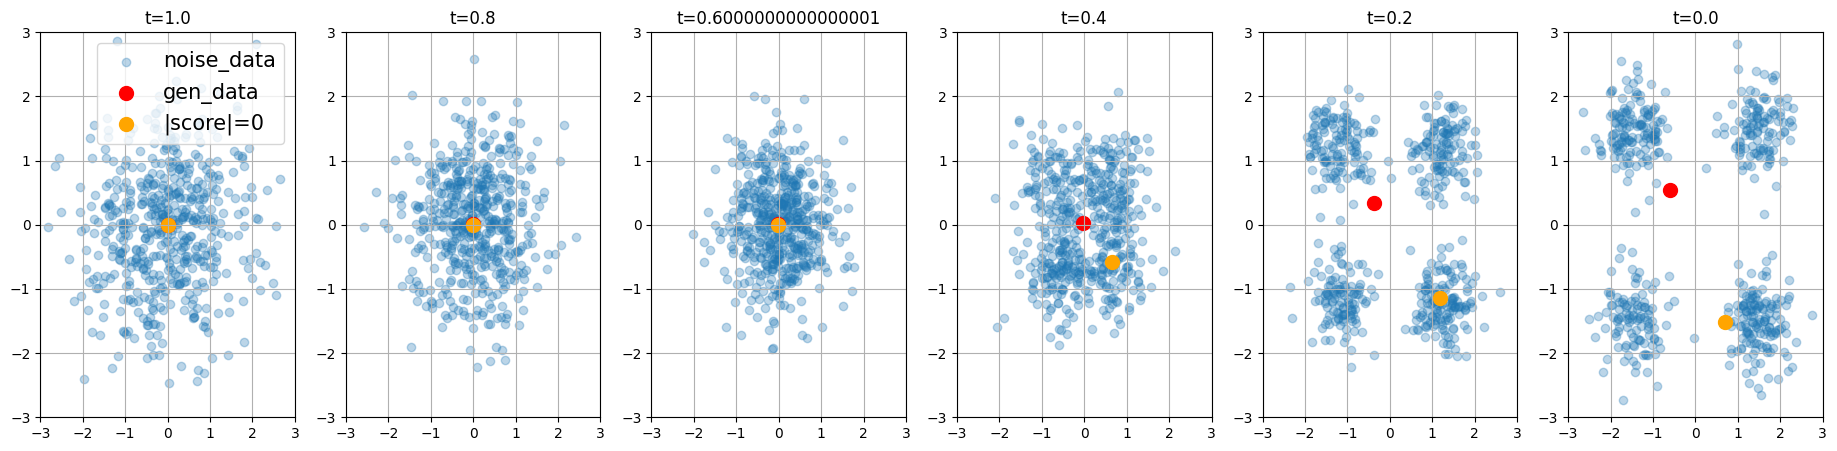

In [21]:
plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], 512), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data', alpha=0.3)
  plt.scatter(x_gen[1,int(n*(t_axis[i])),0], x_gen[1,int(n*(t_axis[i])),1], label='gen_data', s=100, c='red')
  plt.scatter(x_gen[0,int(n*(t_axis[i])),0], x_gen[0,int(n*(t_axis[i])),1], label='|score|=0', s=100, c='orange')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)

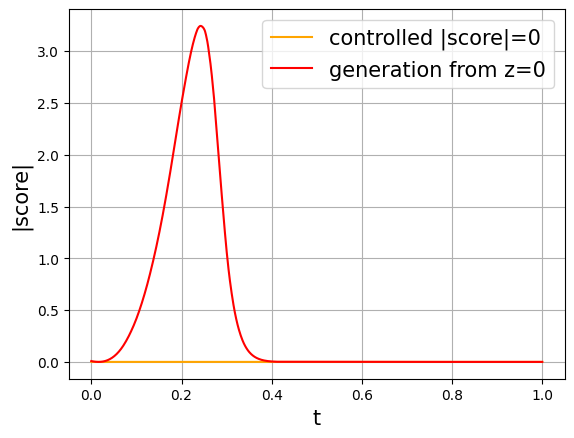

In [22]:
plt.plot(np.linspace(1.0,0.0,n), c[0,:], label='controlled |score|=0', c='orange')
plt.plot(np.linspace(1.0,0.0,n), c[1,:], label='generation from z=0', c='red')
plt.xlabel('t', fontsize=15)
plt.ylabel('|score|', fontsize=15)
plt.legend(fontsize=15)
plt.grid()

## Stochastic

In [ ]:
bs = 512
xi = 1e-4
dt = 1e-4
t = 1.0
n = int(t/dt)
t = t*jnp.ones((bs,1))
x_gen = jnp.zeros((bs,n+1,x_t.shape[1]))
c = np.zeros((bs,n))
for i in trange(n):
  c[:,i] = constant_of_motion(t,x_gen[:,i,:])
  key, ikey = random.split(key, num=2)
  dcdt, dcdx = dcdxdt_fn(t, x_gen[:,i,:])
  dcdt = -dt*dcdt
  dx = -dt*vector_field(t, x_gen[:,i,:], xi) + jnp.sqrt(2*xi*beta(t)*dt)*random.normal(ikey, shape=(bs,2))
  dx = dx-((dcdx*dx).sum(1, keepdims=True)+dcdt)*(dcdx/(jnp.linalg.norm(dcdx, axis=1, keepdims=True)**2))
  x_gen = x_gen.at[:,i+1,:].set(x_gen[:,i,:] + dx)
  t += -dt

  0%|          | 10/10000 [00:00<01:41, 98.33it/s]

100%|██████████| 10000/10000 [01:03<00:00, 156.42it/s]


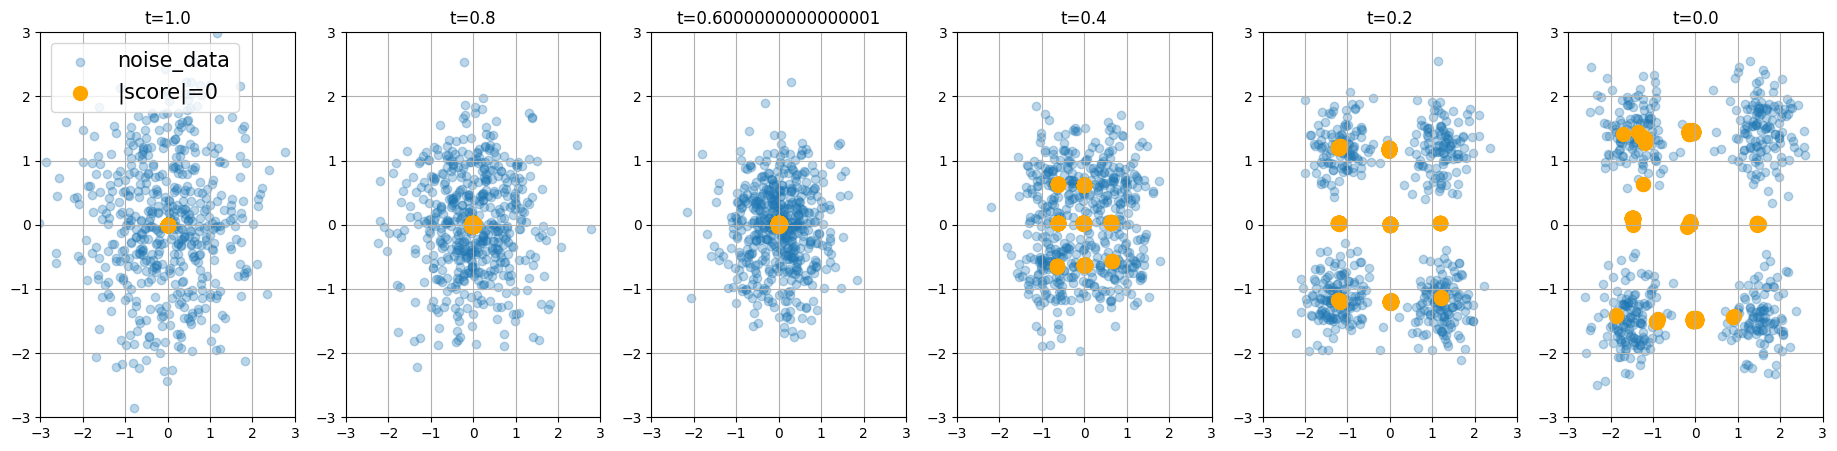

In [46]:
plt.figure(figsize=(23,5))
for i in range(len(t_axis)):
  plt.subplot(1,len(t_axis),i+1)
  key, *ikey = random.split(key, 3)
  t = t_axis[len(t_axis)-1-i]
  _, x_t = q_t(ikey[1], sample_data(ikey[0], 512), t)
  plt.scatter(x_t[:,0], x_t[:,1], label='noise_data', alpha=0.3)
  plt.scatter(x_gen[:,int(n*(t_axis[i])),0], x_gen[:,int(n*(t_axis[i])),1], label='|score|=0', s=100, c='orange')
  plt.title(f't={t}')
  plt.xlim(-3,3)
  plt.ylim(-3,3)
  plt.grid()
  if i == 0:
    plt.legend(fontsize=15)

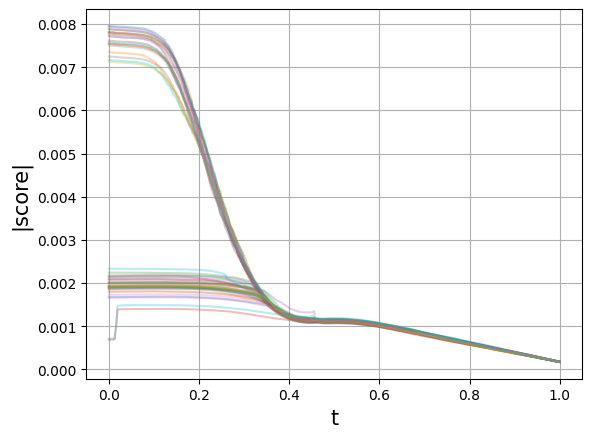

In [25]:
plt.plot(np.linspace(1.0,0.0,n), c[:50,:].T, alpha=0.3)
plt.xlabel('t', fontsize=15)
plt.ylabel('|score|', fontsize=15)
plt.grid()